In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np

base_dir = '/ebs/.cache/ubuntu'

In [30]:
def all_dirs_with_prefix(prefix):
    return [os.path.join(base_dir, d) for d in os.listdir(base_dir) if d.startswith(prefix)]

all_sft_dirs = [os.path.join(cdir, p) for cdir in all_dirs_with_prefix('final_ds') for p in os.listdir(cdir) if p.startswith('epoch')]
base_eval_dir = ['/ebs/.cache/ubuntu/llama7b_samples/alpaca_eval_nsamples1_maxlen512']
all_dpo_dirs = [os.path.join(cdir, p) for cdir in all_dirs_with_prefix('DS_') for p in os.listdir(cdir) if p.startswith('epoch')]
eval_list = ['gpt4', 'claude_1', 'claude_2']

In [44]:
print(all_dpo_dirs)
winrate = {}
for cdir in base_eval_dir + all_sft_dirs + all_dpo_dirs:
    try:
        name = open(os.path.join(cdir, 'name.txt')).read().splitlines()[0]
    except:
        continue
    print(name)
    winrate[name] = {}
    for eval in eval_list:
        try:
            leaderboard = open(os.path.join(cdir, eval, 'leaderboard.csv')).read().splitlines()
        except:
            continue
        for row in leaderboard:
            if row.split(',')[0] == name:
                print(f'{eval} score for {name}: {row.split(",")[1]}')
                winrate[name][eval] = float(row.split(",")[1])

['/ebs/.cache/ubuntu/DS_c2prefs0.1_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-22-34_462251/epoch-3', '/ebs/.cache/ubuntu/DS_c2prefs0.1_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-22-34_462251/epoch-6', '/ebs/.cache/ubuntu/DS_c2prefs0.1_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-22-34_462251/epoch-9', '/ebs/.cache/ubuntu/DS_c2prefs0.1_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-22-34_462251/epoch-12', '/ebs/.cache/ubuntu/DS_c2prefs0.25_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-25-37_081039/epoch-3', '/ebs/.cache/ubuntu/DS_c2prefs0.25_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-25-37_081039/epoch-6', '/ebs/.cache/ubuntu/DS_c2prefs0.25_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-25-37_081039/epoch-9', '/ebs/.cache/ubuntu/DS_c2prefs0.25_llama7b_dpob0.05_sft0.1e3_2023-10-11_18-25-37_081039/epoch-12', '/ebs/.cache/ubuntu/DS_c2prefs0.5_llama7b_dpob0.05_sft0.1e3_2023-10-12_07-24-16_138480/epoch-3', '/ebs/.cache/ubuntu/DS_c2prefs0.5_llama7b_dpob0.05_sft0.1e3_2023-10-12_07-24-16_138480/epoch-6', '/ebs/.cache/ubuntu/DS_

0 gpt4
1 claude_1
2 claude_2


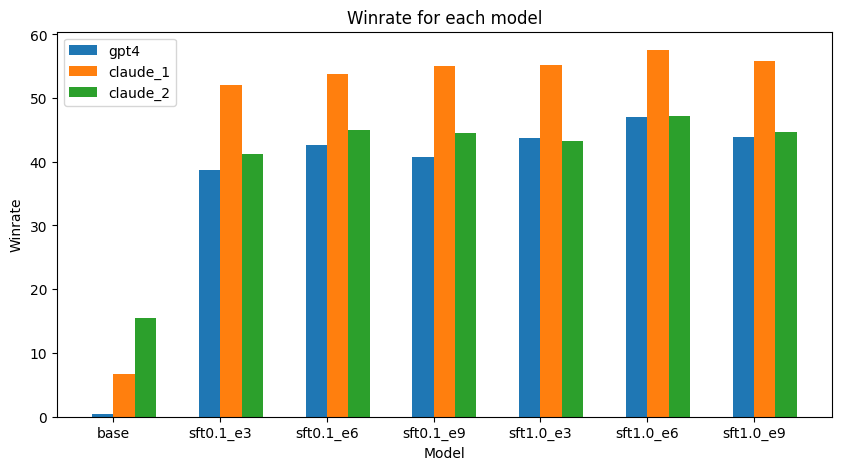

In [45]:
# plot the winrate for each model

fig, ax = plt.subplots(figsize=(10, 5))
width = 0.2
x = np.arange(len(winrate.keys()))
for i, eval in enumerate(eval_list):
    print(i, eval)
    ax.bar(x + width*i, [winrate[name][eval] for name in winrate.keys()], width, label=eval)
ax.set_xticks(x + width/2)
label_keys = [key[len('llama7b_'):] for key in list(winrate.keys())]
ax.set_xticklabels(label_keys)
ax.legend()
ax.set_ylabel('Winrate')
ax.set_xlabel('Model')
ax.set_title('Winrate for each model')
plt.show()
